In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# DataSet

In [ ]:
import pandas as pd
GEB = pd.read_csv("/content/gdrive/My Drive/csy/Capstone Design Data _tpm.csv",index_col= 0)  # col : cell line, index : gene 으로 구성된 데이터프레임
GEB_IC = GEB.iloc[37262:37267,:]
GEB_ = GEB.iloc[:37262,:]
real_index = GEB_.index

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [ ]:
import numpy as np
log = np.log(GEB_IC.iloc[3,:].astype("float"))         # Target 값인 IC50 Value를 얻어내는 과정
log = log.T
log = pd.DataFrame(log)
log['target'] = log['IC50'].apply(lambda x : 1
                                  if (x > 5)
                                  else 0)
log = log.astype('object')
log = log.drop(['IC50'], axis = 1)
log = log.T

In [ ]:
import numpy as np
dataset = np.load('/content/gdrive/My Drive/csy/dataset_KEGG.npz', allow_pickle=True)
adj_list = dataset['adj_list']   # 각 pathway 별 인접행렬
b_list = dataset['b_list']       # 각 pathway에 속해 있는 gene list
adj_list = adj_list
proteins_by_pathway = b_list

In [ ]:
unique = np.unique(sum(proteins_by_pathway, []))             
gene_index = dict(zip(unique, np.zeros(len(unique))))
for i in b_list:
  for j in i:
    gene_index[j] += 1
import collections
sorted_by_value = sorted(gene_index.items(), key=lambda x : x[1], reverse=True)
sorted_dict = collections.OrderedDict(sorted_by_value)
#print(sorted_dict)
gene_index = list(sorted_dict.keys())
new_gene_indexing = []
for ind, k in enumerate(gene_index):
  if ((ind+1)%2==1):
    new_gene_indexing.insert(0, k)
  else:
    new_gene_indexing.append(k)


# Graph Model Code

In [ ]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import scipy.sparse as sp
def clones( module, N):
    return nn.ModuleList(copy.deepcopy(module) for _ in range(N))

class GCNLayer(nn.Module):                                                  # 가장 기본적인 GCN Layer 생성
    
    def __init__(self, in_dim, out_dim, bn=True, num_head=1):                          
        super(GCNLayer, self).__init__()
        self.use_bn = bn                                                    # layer를 통과할 때 마다 포함된 값들을 normalization
        self.linear = nn.Linear(in_dim, out_dim)                            # 각 노드의 feature에 weight와 bias 부여 
        #nn.init.xavier_uniform_(self.linear.weight)
        nn.init.kaiming_normal_(self.linear.weight)
        #self.bn = nn.BatchNorm1d(out_dim)
        self.attention = Attention(out_dim, out_dim, num_head)
    
        
        
    def forward(self, x, adj):
        out = self.linear(x)
        
        out = self.attention(out,adj)
       # out = self.bn(out)
        #norm = nn.LayerNorm(out.shape[2], elementwise_affine=False)
        #out = norm(out)                                                  # Activation function, 음수 값은 0으로 내보내는 Relu가 아닌 음수일 때 그 값을 exponenetial 값을 취해주는
        out = F.relu(out)                                                # Elu 함수를 사용
        #out = F.elu(out,alpha=1.0) 
        return out, adj                                                              

class SkipConnection(nn.Module):                                            # ResNet처럼 GCN Block이 통과할 때마다 이전 값을 포함해주는 skip connection 기능을 수행
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x                                                  # GCNBlock class 안에서는 in_x : residual(전 block에서 생성된 output), output : 현재 Block에서 생성된 output 
        return out

class GatedSkipConnection(nn.Module):                                       # residual 학습을 할 때 z_coefficient를 추가하여 residual값과 해당 block output 값의 중요도를 계산하여 추가
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.xavier_uniform_(self.linear_coef_in.weight)
        nn.init.xavier_uniform_(self.linear_coef_out.weight)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

class GCNBlock(nn.Module):                                                 # 앞서 언급되었던 GCN Layer와 skip connection 기능을 모두 포함하고 있는 GCN Block 생성
    
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, sc, bn=True): 
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,            # n_layer 만큼 GCN layer를 생성하여 nn.MouduleList()에 추가
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        bn=True))
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x                                                      
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = F.relu(out)
        return out, adj
class Attention(nn.Module):
    
    def __init__(self, in_dim, output_dim, num_head):
        super(Attention, self).__init__()
        
        self.num_head = num_head # multi-head attention: num_head>1
        self.atn_dim = output_dim // num_head
        
        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))       # H*W를 만들어주는 과정 [gene X self.atn_dim]
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim) # attention_dim*attention_dim matrix(C)
            nn.init.xavier_uniform_(corelation)
            self.corelations.append(nn.Parameter(corelation))
      
        self.tanh = nn.Tanh()
        
    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x) # num_aton * attention_dim     
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)
        
        return output
            
    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj,ij->aki', (x_transformed, corelation))
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)
        alpha = self.tanh(alpha)
        return alpha

class ReadOut(nn.Module):                                                # GCN Block을 거쳐 나온 matrix 값을 Nx1 크기로 Flatten (size는 해당 pathway에 속해있는 gene의 개수)
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        #nn.init.xavier_uniform_(self.linear.weight)
        nn.init.kaiming_normal_(self.linear.weight)
        self.activation = act
        #self.norm = nn.LayerNorm(out_dim, elementwise_affine=False)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 2)
        if self.activation != None:
            out = self.activation(out)
        #norm = nn.LayerNorm(out.shape[1], elementwise_affine=False)
        #out = norm(out)
        return out



--------------Transformer Code--------------------------

# Transformer Code

In [ ]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hidden_dim,  n_heads, dropout_ratio, device):
    super().__init__()
    assert hidden_dim % n_heads == 0

    self.hidden_dim = hidden_dim # 임베딩 차원 -> encoder에서는 gene개수
    self.n_heads = n_heads # head 수 -> 아마 1도 해도 될지도..??
    self.head_dim = hidden_dim//n_heads # 각 헤드의 임베딩 차원 

    self.fc_q = nn.Linear(hidden_dim, hidden_dim, bias = False) # Weight(query)
   
    self.fc_k = nn.Linear(hidden_dim, hidden_dim, bias = False) # Weight(key)
    
    self.fc_v = nn.Linear(hidden_dim, hidden_dim, bias = False) # Weight(value)

    self.fc_o = nn.Linear(hidden_dim, hidden_dim, bias = False) ## True로 바꿔주기
    
    nn.init.xavier_uniform_(self.fc_q.weight)
    nn.init.xavier_uniform_(self.fc_k.weight)
    nn.init.xavier_uniform_(self.fc_v.weight)
    
    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self, query, key, value, mask = True):
    batch_size = query.shape[0]
    # query: [batch_size, query_len, hidden_dim] -> [batch_size, pathway, gene]
    # key: [batch_size, key_len, hidden_dim]     -> [batch_size, pathway, gene]
    # value: [batch_size, value_len, hidden_dim] -> [batch_size, pathway, gene]


    Q = self.fc_q(query)
    
    K = self.fc_k(key)
  
    V = self.fc_v(value)
  
    # Q: [batch_size, query_len, hidden_dim] -> [batch_size, pathway, gene]
    # K: [batch_size, key_len, hidden_dim]   -> [batch_size, pathway, gene]
    # V: [batch_size, value_len, hidden_dim] -> [batch_size, pathway, gene]


    # hidden_dim → n_heads X head_dim 형태로 변형
    # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도   
    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    # Q: [batch_size, n_heads, query_len, head_dim] -> [batch_size, n_heads, Q_pathway, gene//n_heads]
    # K: [batch_size, n_heads, key_len, head_dim]   -> [batch_size, n_heads, K_pathway, gene//n_heads]
    # V: [batch_size, n_heads, value_len, head_dim] -> [batch_size, n_heads, V_pathway, gene//n_heads]  


    
 
    # Attention Energy 계산
    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale  # K.permute(0, 1, 3, 2) : K의 역행렬
    # energy: [batch_size, n_heads, Q_pathway, K_pathway]
    
    #if mask==True:
      
    #  criter = torch.zeros(energy.shape).to('cuda')
    #  boool = criter == energy
    #  energy = energy.masked_fill(boool==True, 0)      
      

    # mask를 사용할 경우, 0일 때 -1e10으로 채우기


    #softmax 함수 제거
    attention = torch.relu(energy) # K_pathway에 대하여
 
    # attention: [batch_size, n_heads, Q_pathway, K_pathway]

    
    # 여기에서 Scaled Dot-Product Attention을 계산
    x = torch.matmul(self.dropout(attention), V)
    # x: [batch_size, n_heads, Q_pathway, gene//n_heads]
    x = torch.relu(x)
 
    x = x.permute(0, 2, 1, 3).contiguous()
    # x: [batch_size, Q_pathway, n_heads, gene//n_heads]


    x = x.view(batch_size, -1, self.hidden_dim)
    # x: [batch_size, Q_pathway, gene]


    x = self.fc_o(x)
    # x: [batch_size, Q_pathway, gene]


    return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        #self.fc_1 = nn.Linear(hidden_dim, pf_dim)  # hidden_dim -> gene
        #self.fc_2 = nn.Linear(pf_dim, hidden_dim)  # pf_dim -> 아무 숫자 bias = False
        self.fc_1 = nn.Linear(hidden_dim, pf_dim, bias = False)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim, bias = False)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, Q_pathway, gene]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, Q_pathway, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, Q_pathway, gene]

        return x
class EncoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    super().__init__()

    #self.self_attn_layer_norm = nn.LayerNorm(hidden_dim) # encoder단계에서 첫번째 norm
    #self.ff_layer_norm = nn.LayerNorm(hidden_dim) # encoder단계에서 두번째 norm
    self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
    self.dropout = nn.Dropout(dropout_ratio)


  def forward(self, src, src_mask):
      # src: [batch_size, pathway, gene]    
      # src_mask: [batch_size, pathway]


    # self attention
    # 필요한 경우 masking 사용
    _src, _ = self.self_attention(src, src, src, src_mask)
    # dropout, residual connection and layer norm
    
    #src = self.self_attn_layer_norm(src + self.dropout(_src))
    src = src+self.dropout(_src)
 
    # src: [batch_size pathway, gene]
    


    # position-wise feedforward
    _src = self.positionwise_feedforward(src)
    # dropout, residual and layer norm
    #src = self.ff_layer_norm(src + self.dropout(_src))
    src = src+self.dropout(_src)
    # src: [batch_size pathway, gene]

    return src

class Encoder(nn.Module):
  def __init__(self, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device):
    super().__init__()
    self.device = device

    self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)


  def forward(self, src, src_mask):  # final input data In GCN process
        # src: [batch_size, pathway, gene]    
        # src_mask: [batch_size, pathway]
    
    
    for layer in self.layers:
      src = layer(src, src_mask)
      # src: [batch_size, pathway, gene]

    return src  # src: [batch_size, pathway, gene]

In [ ]:
import torch.nn as nn

class DE_MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hidden_dim, de_hidden_dim,  n_heads, dropout_ratio, device):
    super().__init__()
    assert hidden_dim % n_heads == 0

    self.hidden_dim = hidden_dim # 임베딩 차원 -> encoder에서는 gene개수
    self.n_heads = n_heads # head 수 -> 아마 1도 해도 될지도..??
    self.head_dim = hidden_dim//n_heads # 각 헤드의 임베딩 차원 
    self.de_head_dim = de_hidden_dim//n_heads
    self.fc_q = nn.Linear(de_hidden_dim, de_hidden_dim, bias = False) # Weight(query)
   
    self.fc_k = nn.Linear(hidden_dim, hidden_dim, bias = False) # Weight(key)
    
    self.fc_v = nn.Linear(hidden_dim, hidden_dim, bias = False) # Weight(value)

    self.fc_o = nn.Linear(hidden_dim, hidden_dim, bias = False) 

    self.dropout = nn.Dropout(dropout_ratio)
    
    nn.init.xavier_uniform_(self.fc_q.weight)
    nn.init.xavier_uniform_(self.fc_k.weight)
    nn.init.xavier_uniform_(self.fc_v.weight)
    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self, query, key, value, mask = None):
    batch_size = query.shape[0]
    # query: [batch_size, query_len, hidden_dim] -> [batch_size, gene, pathway]
    # key: [batch_size, key_len, hidden_dim]     -> [batch_size, pathway, gene]
    # value: [batch_size, value_len, hidden_dim] -> [batch_size, pathway, gene]

    Q = self.fc_q(query)

    K = self.fc_k(key)
 
    V = self.fc_v(value)
  
    # Q: [batch_size, query_len, hidden_dim] -> [batch_size, gene, pathway]
    # K: [batch_size, key_len, hidden_dim]   -> [batch_size, pathway, gene]
    # V: [batch_size, value_len, hidden_dim] -> [batch_size, pathway, gene]
    

    # hidden_dim → n_heads X head_dim 형태로 변형
    # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도   
    #Q = Q.view(batch_size, -1, self.n_heads, self.de_head_dim).permute(0, 2, 1, 3)
    #K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    #V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    # Q: [batch_size, n_heads, query_len, head_dim] -> [batch_size, n_heads, gene//n_heads, Q_pathway]
    # K: [batch_size, n_heads, key_len, head_dim]   -> [batch_size, n_heads, K_pathway, gene//n_heads]
    # V: [batch_size, n_heads, value_len, head_dim] -> [batch_size, n_heads, V_pathway, gene//n_heads]  
  
 
    #print(Q.shape, K.shape)
    # Attention Energy 계산
    energy = torch.matmul(Q, K) / self.scale  # K.permute(0, 1, 3, 2) : K의 역행렬
    # energy: [batch_size, gene, gene]

  
    # mask를 사용할 경우, 0일 때 -1e10으로 채우기
   # if mask==True:
      
   #   criter = torch.zeros(energy.shape).to('cuda')
   #   boool = criter == energy
   #   energy = energy.masked_fill(boool==True, 0)

    # softmax 함수 제거
    attention = torch.relu(energy) # K_pathway에 대하여
    # attention: [batch_size, n_heads, gene, gene]
    
    # 여기에서 Scaled Dot-Product Attention을 계산
    
    x = torch.matmul(self.dropout(attention), V.permute(0, 2, 1))
    # V.permute(0, 1, 3, 2) : [batch_size, n_heads, gene//n_heads, pathway]
    # x: [batch_size, n_heads, Q_pathway, gene//n_heads]
    x = torch.relu(x)
    
    #x = x.permute(0, 2, 1, 3).contiguous()
    # x: [batch_size, gene//n_heads,  n_heads, Q_pathway]


    #x = x.view(batch_size, -1, self.hidden_dim)
    # x: [batch_size, Q_pathway, gene]


    #x = self.fc_o(x)
    # x: [batch_size, gene, pathway]


    return x, attention

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, hidden_dim, de_hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    super().__init__()

    #self.self_attn_layer_norm = nn.LayerNorm(de_hidden_dim)
    #self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
    self.ff_layer_norm = nn.LayerNorm(hidden_dim)
    
    self.self_attention = MultiHeadAttentionLayer(de_hidden_dim, n_heads, dropout_ratio, device)
    #self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.encoder_attention = DE_MultiHeadAttentionLayer(hidden_dim,de_hidden_dim, n_heads, dropout_ratio, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(de_hidden_dim, pf_dim, dropout_ratio)
    self.dropout = nn.Dropout(dropout_ratio)
    self.fc_in_dim = hidden_dim*de_hidden_dim
    self.fincal_fc1 = nn.Linear(self.fc_in_dim, 10000, bias = False)  # bias = True로 변경해주어야 함
    self.fincal_bn1 = nn.BatchNorm1d(10000)
    self.fincal_fc2 = nn.Linear(10000, 100, bias = False)
    self.fincal_bn2 = nn.BatchNorm1d(100)
    self.fincal_fc3 = nn.Linear(100, 2, bias = False)
    self.final_fc = nn.Linear(self.fc_in_dim, 2, bias = False)

  def forward(self, trg, enc_src, trg_mask, src_mask):
    # trg : [batch_size, trg_len, hidden_dim] - > [batch_size, gene, pathway]  ->  src와 반대
    # enc_src : [batch_size, src_len, hidden_dim] - > [batch_size, pathway, gene]
    # trg_mask: [batch_size, trg_len] - > [batch_size, gene]
    # src_mask: [batch_size, src_len] - > [batch_size, pathway]

    
    # self attention
    # Output Embeding Matrix에 대하여 self attention
    _trg, _ = self.self_attention(trg, trg, trg, trg_mask) 
   
    # dropout, residual connection and layer norm
    #trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
    trg = trg + self.dropout(_trg)
    # trg: [batch_size, trg_len, hidden_dim] - > [batch_size, gene, pathway]
    

    ##중요##
    # Encoder Attention
    # Decoder의 query를 Encoder의 key, value를 이용하여 Attention
    _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask) ## 이 때 우리의 경우에는 Key matrix에 역행렬을 취해주면 안됌. 별도의 코드 필요!!
   
    
    # dropout, residual connection and layer norm
  
    #trg = self.enc_attn_layer_norm(trg+self.dropout(_trg))
    trg = trg + self.dropout(_trg)
    # trg: [batch_size, gene, pathway]
    

    # positionwise feedforward
    _trg = self.positionwise_feedforward(trg)
    
    # dropout, residual and layer norm
    #trg = self.ff_layer_norm(trg + self.dropout(_trg))
    trg = trg + self.dropout(_trg)

    # trg: [batch_size, gene, pathway]
    # attention: [batch_size, n_heads, trg_len, src_len] -> [batch_size, n_heads, gene, pathway]
    ## attention은 concat 하기 전이기 때문에 n_heads가 남아있음
    trg_conti = trg.contiguous()
   
    readout = trg_conti.view(trg.shape[0], -1)
    #output = self.fincal_fc1(readout)
    #output = self.fincal_bn1(output)
    #output = self.fincal_fc2(output)
    #output = self.fincal_bn2(output)
    #output = self.fincal_fc3(output)
    output = self.final_fc(readout)
    return output, trg, attention


class Transformer(nn.Module):
  def __init__(self, hidden_dim, de_hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device):
    super().__init__()

    self.device = device

   
    self.encoder = Encoder(hidden_dim,n_layers, n_heads ,pf_dim, dropout_ratio, device) # n_heads
    self.decoder = DecoderLayer(hidden_dim, de_hidden_dim, n_heads, pf_dim, dropout_ratio, device)

  def forward(self, src, trg):
    enc_src = self.encoder(src, src_mask=True)
    
    output, t, attention = self.decoder(trg, enc_src, trg_mask=True, src_mask=True)

    return output, t, attention

    ## output은 size가 2인 텐서 형태로... ...




      #  [gene 수,    pathway 수 ... ...]  

# GCN -> CNN 학습코드 정의

In [ ]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
def cell_line_dicimal_norm(G):
   GEB1 = GEB_[[G]]
   GEB1 = GEB1.astype('float')
   GEB1 = mean_norm(GEB1)
   protein_features_df = GEB1.T
   protein_features_df = protein_features_df.astype('float64')
   return protein_features_df
def cell_line_dicimal(G):
   GEB1 = GEB_[[G]]
   GEB1 = GEB1.astype('float')
   GEB1 = GEB1/292290725368.0
   protein_features_df = GEB1.T
   protein_features_df = protein_features_df.astype('float64')
   return protein_features_df
#################################
def cell_line_binary(G):                                         # gene expression 값이 Float 형태였던 데이터형태를 이진수로 변환해주는 함수
        GEB1 = GEB_[[G]]
        GEB1['B'] = GEB1[G].astype('str').str.zfill(24)
        non_dot_list = []
        for i in GEB1['B'].values:
          i = i.replace(".", "0")
          non_dot_list.append(i)
        GEB1['B'] = non_dot_list
        GEB2 = GEB1[['B']]
        dat = [list(map(int, str(x).zfill(6))) for x in GEB2.B]
        d = pd.DataFrame(dat, GEB2.index).rename(columns=lambda x: f'2^{23 - x}')
        GEB2.join(d)

        protein_features_df = GEB2.join(d).drop(['B'], axis = 1)
        protein_features_df = protein_features_df.transpose()

        return protein_features_df
##################################        
def selection(pathway_gene):                                    # 최종적으로 만들어진 GCN output의 크기가 6000x1로 너무 커서 모든 pathway에 값이 0으로 되어 있는 gene을 제거하여  
                                                                # 400~500 x 1 형태로 변환       
    row_list = []
    pathway_gene_ = pathway_gene[0,:,:]
    for row in range(pathway_gene_.shape[1]):
      if (sum(pathway_gene_[:,row] == 0)) < 295 :
        row_list.append(row)
    return pathway_gene[:,:,row_list]

##################################
def normalize_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)) # D
    d_inv_sqrt = np.power(rowsum, -0.5).flatten() # D^-0.5
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt) # D^-0.5
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).toarray()

class GraphResNet(nn.Module):
    def __init__(self):
        super(GraphResNet, self).__init__()     
        self.GCN_layer = nn.ModuleList()                                # GCN Block과 readout을 포함하고 있는 nn.ModuleList() 생성
        self.GCN_layer.append(GCNBlock(2, 1, 2, 2, sc='gsc'))       # nn.Mouduleist()에 포함되어 있는 class 들은 for문을 통해 그 안에 속해있는 모든 function들을 수행
        self.GCN_layer.append(GCNBlock(2, 2, 2, 2, sc='gsc'))       # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html?highlight=nn%20modulelist#torch.nn.ModuleList.append
        self.GCN_layer.append(GCNBlock(2, 2, 2, 2, sc='gsc')) 
        self.GCN_layer.append(ReadOut(2, 1))
        self.GCN_layer_list = nn.ModuleList()
        for _ in list(range(308)):
          self.GCN_layer_list.append(self.GCN_layer) 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1,5), stride=1, bias = False)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(1,5), stride=1, bias = False)
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(1,5), stride=1, bias = False)
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1,5), stride=1, bias = False)
        #self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=5, stride=1)
        #self.conv6 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=5, stride=1)
       
        self.fc1 = nn.Linear(44352, 500) ###### !!!!!!!!!!중요!!!!!!!!!!!!!!! gene 개수 다를 때 바꾸어주어야 할 부분
        self.fc2 = nn.Linear(500, 2)
       


    def forward(self, bat_tensor):                      # randome_train_list : 800개의 cell line 중 미리 random 함수를 통해 700개의 cell line list 생성
        
        batch_size = bat_tensor.shape[0]                                                                   # 메모리 문제로 batch_size를 호출 받아 직접 쌓는 방식으로 구현            
          
        pre_input_tensor = []                                              # [batch, 1, H, W] 형태로 최종 CNN input 텐서 생성
        random_cell_line = []        
        uni_list_prot = np.unique(sum(proteins_by_pathway, []))                  
        indexing = dict(zip(new_gene_indexing, np.arange(len(uni_list_prot))))
        i_ = list(range((342)))        
        protein_features_df = GEB_.T                                          
        col_list = list(protein_features_df.columns)
        pathway_gene = []
        for i, adj, b in zip(i_, adj_list, b_list):                         # Pathway 별로 GCN 연산 수         
          ##
          col_gene_ind = []
          for col_gene in b:
            col_gene_ind.append(col_list.index(col_gene))
     
          x = bat_tensor[:,col_gene_ind,:]
          adj = normalize_adj(adj)         
          x, adj = torch.tensor(x).to('cuda').float(), torch.tensor(adj).to('cuda').float()  
       
          for k, layer in enumerate(self.GCN_layer_list[i]): 
            if k != 3:                                                 
              out, adj = layer((x if k==0 else out), adj)             
        
            else:              
              output = layer(out)
         
      
          fix_list = torch.zeros([batch_size, len(uni_list_prot)])
          for batch in range(batch_size):
            for gene_index, gene in enumerate(b):
              fix_list[batch, indexing[gene]] = output[batch, gene_index]
          
          
          pathway_gene.append(fix_list)
        pathway_gene_ = torch.stack(pathway_gene, dim = 1) 
        
        #pathway_gene = selection(pathway_gene_)
        pathway_gene = pathway_gene_
        
        input_data_depth10 = pathway_gene.to('cuda').float()
      
        x = input_data_depth10[:,np.newaxis,:,:]                            
      
        ###### !!!!!!!!!!중요!!!!!!!!!!!!!!! gene 개수 다를 때 바꾸어주어야 할 부분
       
        x = F.relu(self.conv1(x))                              # 아래의 과정은 기본적인 CNN 연산
        
        x = F.max_pool2d(x, kernel_size=(1,5), stride=(1,5))
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=(1,5), stride=(1,5))
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=(1,5), stride=(1,5))

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=(1,5), stride=(1,5))

       

                                            
        #print('제발 잘 학습해줘....')
        x = x.view(batch_size, -1)   ###### !!!!!!!!!!중요!!!!!!!!!!!!!!! gene 개수 다를 때 바꾸어주어야 할 부분
       
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)        
        T = 0  
        return x, T

# GCN -> Transformer 학습 코드 정의

In [ ]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

def cell_line_dicimal_norm(G):
   GEB1 = GEB_[[G]]
   GEB1 = GEB1.astype('float')
   GEB1 = mean_norm(GEB1)
   protein_features_df = GEB1.T
   protein_features_df = protein_features_df.astype('float64')
   return protein_features_df

def cell_line_dicimal(G):
   GEB1 = GEB_[[G]]
   GEB1 = GEB1.astype('float')
   GEB1 = GEB1/292290725368.0
   protein_features_df = GEB1.T
   protein_features_df = protein_features_df.astype('float64')
   return protein_features_df
   
def cell_line_binary(G):                                         # gene expression 값이 Float 형태였던 데이터형태를 이진수로 변환해주는 함수
        GEB1 = GEB_[[G]]
        GEB1['B'] = GEB1[G].astype('str').str.zfill(24)
        non_dot_list = []
        for i in GEB1['B'].values:
          i = i.replace(".", "0")
          non_dot_list.append(i)
        GEB1['B'] = non_dot_list
        GEB2 = GEB1[['B']]
        dat = [list(map(int, str(x).zfill(6))) for x in GEB2.B]
        d = pd.DataFrame(dat, GEB2.index).rename(columns=lambda x: f'2^{23 - x}')
        GEB2.join(d)
        protein_features_df = GEB2.join(d).drop(['B'], axis = 1)
        protein_features_df = protein_features_df.transpose()
        return protein_features_df
    
def selection_(pathway_gene):                      # 최종적으로 만들어진 GCN output의 크기가 6000x1로 너무 커서 모든 pathway에 값이 0으로 되어 있는 gene을 제거하여                                                         
    row_list = []                                  # 400~500 x 1 형태로 변환    
    pathway_gene_ = pathway_gene[0,:,:]
    for row in range(pathway_gene_.shape[1]):
      if (sum(pathway_gene_[:,row] == 0)) < 275 :
        row_list.append(row)
    return pathway_gene[:,:,row_list]

def selection(b_list, pathway_gene):                                                                                             
    node_count = []
    for  i in b_list:
      node_count.append(len(i))
    node_count_sort = np.sort(node_count)
    path_sele = list(pd.Series(node_count).sort_values()[:300].index)
    path_sele.sort()         
    row_list = []
    pathway_gene_ = pathway_gene[0,path_sele,:]
    for row in range(pathway_gene_.shape[1]):
      if (sum(pathway_gene_[:,row] == 0)) < 299 :
        row_list.append(row)
    pathway_gene = pathway_gene[:,path_sele,:]
    pathway_gene = pathway_gene[:,:,row_list]
    return pathway_gene

def std_selection(GEB_, new_gene_indexing, pathway_gene):
    val_GEB = GEB_.loc[new_gene_indexing,:].astype('float').std(axis=1)
    a = val_GEB>0.25e+9
    b = a.values.tolist()
    c = pd.Series(a.values, index=np.arange(len(a)))
    d = np.array(c[c==True].index)
    return pathway_gene[:,:,d]

def normalize_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)) # D
    d_inv_sqrt = np.power(rowsum, -0.5).flatten() # D^-0.5
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt) # D^-0.5
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).toarray()


##############################################################################
class Attentionisallyouneed(nn.Module):
    def __init__(self, hidden_dim, de_hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device):
        super(Attentionisallyouneed, self).__init__()     
        self.GCN_layer = nn.ModuleList()                                # GCN Block과 readout을 포함하고 있는 nn.ModuleList() 생성
        self.GCN_layer.append(GCNBlock(2, 1, 2, 2, sc='gsc'))       # nn.Mouduleist()에 포함되어 있는 class 들은 for문을 통해 그 안에 속해있는 모든 function들을 수행
        self.GCN_layer.append(GCNBlock(2, 2, 4, 4, sc='gsc'))       # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html?highlight=nn%20modulelist#torch.nn.ModuleList.append
        self.GCN_layer.append(GCNBlock(2, 4, 4, 4, sc='gsc')) 
        self.GCN_layer.append(ReadOut(4, 1))
        self.GCN_layer_list = nn.ModuleList()  
        for _ in list(range(308)):
          self.GCN_layer_list.append(self.GCN_layer)
        self.transformer = Transformer(hidden_dim, de_hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device)
        
    def forward(self, bat_tensor):                                                                
            
        batch_size = bat_tensor.shape[0]
        pre_input_tensor = []                                                      
        pathway_gene = []
        protein_features_df = GEB_.T
        uni_list_prot = np.unique(sum(proteins_by_pathway, []))                  
        indexing = dict(zip(new_gene_indexing, np.arange(len(uni_list_prot))))
        i_ = list(range((342)))                                                    
        col_list = list(protein_features_df.columns)
        pathway_gene = []

        for i, adj, b in zip(i_, adj_list, b_list):                         # Pathway 별로 GCN 연산 수         
          ##
          col_gene_ind = []
          for col_gene in b:
            col_gene_ind.append(col_list.index(col_gene))
          ##
          x = bat_tensor[:,col_gene_ind,:]
          adj = normalize_adj(adj)         
          x, adj = torch.tensor(x).to('cuda').float(), torch.tensor(adj).to('cuda').float()    # x : feature matrix   adj : 각 pathway의 인접행렬
          
          
    # --------------------GCN 학습 과정--------------------------
        
          for k, layer in enumerate(self.GCN_layer_list[i]): 
            if k != 3:                                                           
              out, adj = layer((x if k==0 else out), adj)                     
            else:              
              output = layer(out)
    
          fix_list = torch.zeros([batch_size, len(uni_list_prot)])
          for batch in range(batch_size):
            for gene_index, gene in enumerate(b):
              fix_list[batch, indexing[gene]] = output[batch, gene_index]                          
          pathway_gene.append(fix_list)

        pathway_gene = torch.stack(pathway_gene, dim = 1)  
        pathway_gene = std_selection(GEB_, new_gene_indexing, pathway_gene)       
        input_data_depth10 = pathway_gene
       
        src = input_data_depth10.to('cuda').float()
        trg = src.permute(0, 2, 1).to('cuda').float()
        output, t, attention = self.transformer(src, trg)
        
        return output, t

# GCN -> MLP 학습코드 정의

In [ ]:
class GraphMLP(nn.Module):
    def __init__(self):
        super(GraphMLP, self).__init__()     
        self.GCN_layer = nn.ModuleList()                                # GCN Block과 readout을 포함하고 있는 nn.ModuleList() 생성
        self.GCN_layer.append(GCNBlock(3, 1, 2, 2, sc='gsc'))       # nn.Mouduleist()에 포함되어 있는 class 들은 for문을 통해 그 안에 속해있는 모든 function들을 수행
        self.GCN_layer.append(GCNBlock(3, 2, 1, 1, sc='gsc'))       # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html?highlight=nn%20modulelist#torch.nn.ModuleList.append
        self.GCN_layer.append(GCNBlock(3, 1, 1, 1, sc='gsc')) 
        self.GCN_layer.append(ReadOut(1, 1))
        self.GCN_layer_list = nn.ModuleList()
        for _ in list(range(308)):
          self.GCN_layer_list.append(self.GCN_layer)        
        self.linear1 = nn.Linear(in_features=176, out_features=300, bias=False)    # gene은 총 450개
        self.linear2 = nn.Linear(in_features=300, out_features=300, bias=False)
        self.linear3 = nn.Linear(in_features=300, out_features=150, bias=False)
        self.linear4 = nn.Linear(in_features=150, out_features=1, bias=False)
        self.linear5 = nn.Linear(in_features=176, out_features=100, bias=False)
        self.linear6 = nn.Linear(in_features=100, out_features=1, bias=False)

        self.final = nn.Linear(in_features=308, out_features=2, bias=False) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.linear_list = nn.ModuleList()
        self.linear_layer_list = nn.ModuleList()
        self.linear_list.append(self.linear5)
        self.linear_list.append(self.relu)
        self.linear_list.append(self.dropout)
        self.linear_list.append(self.linear6)
        self.linear_list.append(self.relu)
        for _ in list(range(308)):
          self.linear_layer_list.append(self.linear_list)
    def forward(self, bat_tensor):                      # randome_train_list : 800개의 cell line 중 미리 random 함수를 통해 700개의 cell line list 생성                                                                                   # 메모리 문제로 batch_size를 호출 받아 직접 쌓는 방식으로 구현            
              # 특이하게 forward() 과정에서 batch를 생성 -> [H, W]의 matrix를 직접 쌓아
        batch_size = bat_tensor.shape[0]
        pre_input_tensor = []                                              # [batch, 1, H, W] 형태로 최종 CNN input 텐서 생성              
        pathway_gene = []
        protein_features_df = GEB_.T
        uni_list_prot = np.unique(sum(proteins_by_pathway, []))                  
        indexing = dict(zip(new_gene_indexing, np.arange(len(uni_list_prot))))
        i_ = list(range((342)))                                                    
        col_list = list(protein_features_df.columns)
        pathway_gene = []

        for i, adj, b in zip(i_, adj_list, b_list):                         # Pathway 별로 GCN 연산 수         
          ##
          col_gene_ind = []
          for col_gene in b:
            col_gene_ind.append(col_list.index(col_gene))
          ##

          x = bat_tensor[:,col_gene_ind,:]
          adj = normalize_adj(adj)         
          x, adj = torch.tensor(x).to('cuda').float(), torch.tensor(adj).to('cuda').float()    # x : feature matrix   adj : 각 pathway의 인접행렬

          
            # GCN 학습 과정
        
          for k, layer in enumerate(self.GCN_layer_list[i]): 
            if k != 3:                                                    # -> GCNBlock(GCNLayer 10개) -> GCNBlock(GCNLayer 25개) -> Readout -> gene의 숫자가 size인 텐서 생성 
              
              out, adj = layer((x if k==0 else out), adj)             
        
            else:              
              output = layer(out)
   
          fix_list = torch.zeros([batch_size, len(uni_list_prot)])
          for batch in range(batch_size):
            for gene_index, gene in enumerate(b):
              fix_list[batch, indexing[gene]] = output[batch, gene_index]

          
          pathway_gene.append(fix_list)
        pathway_gene = torch.stack(pathway_gene, dim = 1) 

        #pathway_gene = selection(pathway_gene)
        pathway_gene = std_selection(GEB_, new_gene_indexing, pathway_gene)

       
        input_data_depth10 = pathway_gene
        input_data_depth10 = input_data_depth10.float()
        total_readout = []

        for path, layer_list in enumerate(self.linear_layer_list):
          x = input_data_depth10[:, path,:].to('cuda')
          #x = self.linear1(x)     
          #x = self.relu(x)
          #x = self.dropout(x)

          #x = self.linear2(x)
          #x = self.relu(x)     
          #x = self.dropout(x)

          #x = self.linear3(x)
          #x = self.relu(x)
          #x = self.dropout(x)
          
          #x = self.linear4(x)
          #x = self.relu(x) 

          for layer in layer_list: 
            x = layer(x)
          total_readout.append(x)    

        total_readout = torch.stack(total_readout, dim = 1).to('cuda')
    
        total_readout = total_readout.view(batch_size, -1)
        output = self.final(total_readout)
        t = 0
        return output, t

# Training (1epoch)

In [ ]:
def make_data(GEB, train_set):
  random_cell_line = []       
  bat_tensor = []  
  for cnt, G in enumerate(GEB.columns[list(train_set)]):   
    random_cell_line.append(G)
    #protein_features_df = cell_line_dicimal_norm(G)
    values = cell_line_dicimal(G).T.values
    tensor = torch.from_numpy(values)
    bat_tensor.append(tensor)
  bat_tensor = torch.stack(bat_tensor, dim = 0)
  target = torch.tensor(pd.Series(log[random_cell_line].values[0])).to('cuda')
  return bat_tensor, target  
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp  

def eval(model, eval_list, batch_size):
  model.eval()
  correct = 0
  loss = 0
  with torch.no_grad():
    eval_set = np.random.choice(eval_list, batch_size)
    bat_tensor, target = make_data(GEB, eval_set) 
    output, t = model(bat_tensor)  
    loss = criterion(output, target)
    _, predicted = output.max(1)
    correct = predicted.eq(target).sum().item()
  return 100. * correct / batch_size, loss.item()

import random
random_seed = 1553
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#np.random.seed(random_seed)
random.seed(random_seed)
#torch.cuda.manual_seed(random_seed)
#torch.cuda.manual_seed_all(random_seed) # multi-GPU
device = 'cuda'

------------------여기까지 실행------------------------------

In [ ]:
nums = set()
while len(nums) != 100: 
  nums.add(random.randint(1, 801))
eval_list = list(nums)

train_list = list(range(1, 801))

for i in eval_list:
  train_list.remove(i)

# hidden_dim, de_hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device
#model = Attentionisallyouneed(176, 308, 1, 1, 100, 0, 'cuda').to(device)  # 메모리 때문에 308 -> 89
model = GraphResNet().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.05 ) # lr = 1e-3 or 5e-4, weight_decay=0.00005 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)#, weight_decay=0.1
#optimizer = torch.optim.SparseAdam(model.parameters(), lr=5e-4)        
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0,  verbose = False)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3, verbose = True)
criterion = nn.CrossEntropyLoss()  
print("total parameter 수 : ", get_n_params(model))
# 275664581
# 423843235 -> gene 137
# 544179655 -> gene 176

total parameter 수 :  22181176


In [ ]:

import warnings
warnings.filterwarnings(action='ignore')
batch_size = 16
iterations = 40
loss_list = []
import time
start = time.time()

for iteration in range(iterations):
  train_set = np.random.choice(train_list, batch_size, replace = False)
  for t in train_set:
    train_list.remove(t)
  bat_tensor, target = make_data(GEB, train_set) 
  model.train()
  train_loss = 0 
  optimizer.zero_grad()
  output, t = model(bat_tensor) # 최종 output

  loss = criterion(output, target)
  loss.backward()  # 역전파
  optimizer.step()
  #scheduler.step()
  train_loss += loss.item()

  torch.cuda.empty_cache()
  print(iteration, "번째 iteration")
  print("train loss : ", train_loss)
  loss_list.append(train_loss)
  if iteration % 5 == 0:
    eval_acc, eval_loss = eval(model, eval_list, 64)
    print("\n, eval loss : ", eval_loss,)
    print("eval accuarcy : ", eval_acc, "%")
    print('------------------------------------\n')
  # 중요 point ## 역전파가 제대로 되는지 확인하는 단계 ##  ----print(model.GCN_layer[0].layers[0].linear.weight.grad)----
  #print("time :", (time.time() - start)/60)
print("time :", (time.time() - start)/60)

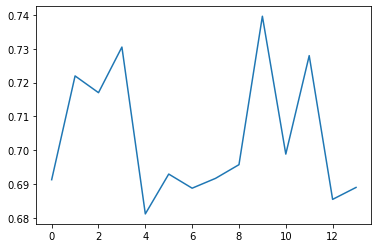

In [ ]:
import seaborn as sns
sns.lineplot(x=np.arange(len(val_loss_list)), y = val_loss_list)
sns.lineplot(x=np.arange(len(loss_list)), y = loss_list)

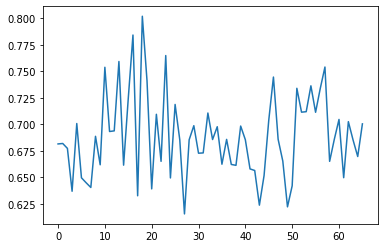

In [ ]:
sns.lineplot(x=np.arange(len(loss_list)), y = loss_list)

# Training( * epoch)

In [ ]:
def make_data(GEB, train_set):
  random_cell_line = []       
  bat_tensor = []  
  for cnt, G in enumerate(GEB.columns[list(train_set)]):   
    random_cell_line.append(G)
    #protein_features_df = cell_line_dicimal_norm(G)
    values = cell_line_dicimal(G).T.values
    tensor = torch.from_numpy(values)
    bat_tensor.append(tensor)
  bat_tensor = torch.stack(bat_tensor, dim = 0)
  target = torch.tensor(pd.Series(log[random_cell_line].values[0])).to('cuda')
  return bat_tensor, target  
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp  
def eval(model, eval_list, batch_size):
  model.eval()
  correct = 0
  loss = 0
  with torch.no_grad():
    eval_set = np.random.choice(eval_list, batch_size)
    bat_tensor, target = make_data(GEB, eval_set) 
    output, t = model(bat_tensor)  
    loss = criterion(output, target)
    _, predicted = output.max(1)
    correct = predicted.eq(target).sum().item()
  return 100. * correct / batch_size, loss.item()

import warnings
warnings.filterwarnings(action='ignore')

import random
random_seed = 1553
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # multi-GPU
#####################################################

In [ ]:
nums = set()
while len(nums) != 100: 
  nums.add(random.randint(1, 801))
eval_list = list(nums)

train_list = list(range(1, 801))
#train_list = []
for i in eval_list:
  train_list.remove(i)
######################################################
 # hidden_dim, de_hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device
device = 'cuda'

#model = Attentionisallyouneed(176, 308, 1, 1, 100, 0.3, 'cuda').to(device)  # 메모리 때문에 308 -> 89
model = GraphResNet().to(device)
#model = GraphMLP().to(device)  

#optimizer = torch.optim.Adam(model.parameters(), lr=5e-1) # lr = 1e-3 or 5e-4, weight_decay=0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.00001)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay = 0.0001)#, weight_decay=0.1
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0,  verbose = False)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()
#model.train()  


print("total parameter 수 : ", get_n_params(model))
# 275664581
# 423843235 -> gene 137
# 544179655 -> gene 176
loss_list = []
val_loss_list = []
import time
start = time.time()
batch_size = 16
iterations = 40
epochs = 10

for epoch in range(epochs):
  #model.train() 
  eval_acc_sum = 0
  epoch_loss = 0
  epoch_val_loss = 0
  train_list = list(range(1, 801))
  #train_list = []
  for i in eval_list:
    train_list.remove(i)
  
  for iteration in range(iterations): 
    train_set = np.random.choice(train_list, batch_size, replace = False)
    for t in train_set:
      train_list.remove(t) 

    bat_tensor, target = make_data(GEB, train_set)   
    model.train()
    train_loss = 0 
    optimizer.zero_grad()
    output, t = model(bat_tensor) # 최종 output
   
    loss = criterion(output, target)
    train_loss += loss.item()
    loss.backward()  # 역전파
    optimizer.step()
    #scheduler.step()
    torch.cuda.empty_cache()
    print()
    print(iteration, "번째 iteration")
    print("train loss : ", train_loss)        
    if iteration % 5 == 0:

      eval_acc, eval_loss = eval(model, eval_list, 64)
      print("\n eval loss : ", eval_loss,)
      print("eval accuarcy : ", eval_acc, "%")
      print('------------------------------------\n')
      eval_acc_sum += eval_acc
      val_loss_list.append(eval_loss)
      epoch_val_loss += eval_loss

    loss_list.append(train_loss)
    epoch_loss += train_loss
    #print(model.linear1.weight.grad)
    #print(model.GCN_layer[3].linear.weight.grad)
  print("------------------EPOCH 완료-----------------------")
  print("Epoch Loss Mean : ", epoch_loss/10)
  print("Epoch Val Loss Mean : ", epoch_val_loss/3)
  print("Epoch eval acc : ", eval_acc_sum/3)
  print("---------------------------------------------------")
  
print("time :", (time.time() - start)/60)

# weight decay : 0,1 ~  0.000001 까지 다양하게 해보기
# adamW 사용해보기

total parameter 수 :  22178495

0 번째 iteration
train loss :  0.6895556449890137

 eval loss :  0.6893316507339478
eval accuarcy :  54.6875 %
------------------------------------


1 번째 iteration
train loss :  0.680005669593811

2 번째 iteration
train loss :  0.6763085722923279

3 번째 iteration
train loss :  0.7491164803504944

4 번째 iteration
train loss :  0.6736153364181519

5 번째 iteration
train loss :  0.7096790075302124

 eval loss :  0.6687981486320496
eval accuarcy :  65.625 %
------------------------------------


6 번째 iteration
train loss :  0.6973009705543518

7 번째 iteration
train loss :  0.6968393325805664

8 번째 iteration
train loss :  0.6662819981575012

9 번째 iteration
train loss :  0.7161306738853455

10 번째 iteration
train loss :  0.6585794687271118

 eval loss :  0.6794791221618652
eval accuarcy :  60.9375 %
------------------------------------


11 번째 iteration
train loss :  0.6771196722984314

12 번째 iteration
train loss :  0.6766840219497681

13 번째 iteration
train loss :  0.70

KeyboardInterrupt: ignored

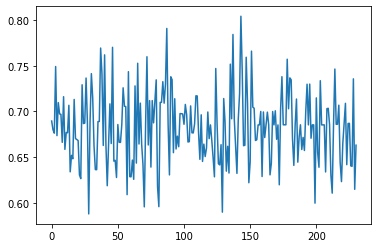

In [ ]:
import seaborn as sns
#sns.lineplot(x=np.arange(len(val_loss_list)), y = val_loss_list)
sns.lineplot(x=np.arange(len(loss_list)), y = loss_list)

# Test

In [ ]:
random_seed = 1553
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # multi-GPU
#####################################################


model.eval()
correct = 0
loss = 0
cnt = 1
#random_test = random.sample(list(range(801)), 5) # 다시 100으로 바꿔주어야 함
with torch.no_grad():
  for interval in range(1,11):
    
    eval_list_ = eval_list[10*(interval-1) : interval*10]
    
    output, sample, t = model(eval_list_, 10) # 최종 output
    target = torch.tensor(pd.Series(log[sample].values[0])).to(device) # target 값
    loss = criterion(output, target)
        #loss.backward()  # 역전파
        #optimizer.step()
    _, predicted = output.max(1)
    correct += predicted.eq(target).sum().item()
    print(cnt, "번째 interval 완료")
    cnt += 1

  print("최종 정확도 : ", 100. * correct / 100)